In [30]:
import os
import scipy.io
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim
from complexPyTorch.complexLayers import ComplexLinear
from complexPyTorch.complexFunctions import complex_relu
import matplotlib.pyplot as plt

In [147]:
# Define the Dataset
class RASPNetDataset(Dataset):
    def __init__(self, data_dir, csv_file, split, limit):
        """
        Args:
            data_dir (string): Directory with all the data.
            csv_file (string): Path to the csv file with labels.
            split (string): 'train' or 'test'.
            limit (int): Number of samples to load.
        """
        self.data_dir = data_dir
        self.split = split
        self.limit = limit

        # Load labels
        labels_df = pd.read_csv(csv_file)
        self.labels = torch.from_numpy(labels_df[['R_idx', 'Az_idx', 'El_idx']].values[:limit].astype(np.float32)) # x, y, z
        self.labels = self.labels

        # Initialize lists to hold features
        features_list = []

        # Paths to real and imaginary folders
        real_dir = os.path.join(data_dir, split)
        imag_dir = os.path.join(data_dir, split)

        # Load all real and imag data into memory
        for i in range(1, limit + 1):
            # Construct file names
            real_file = f'real{i}.mat'
            imag_file = f'imag{i}.mat'

            real_path = os.path.join(real_dir, real_file)
            imag_path = os.path.join(imag_dir, imag_file)

            # Load .mat files
            try:
                real_data = scipy.io.loadmat(real_path)['Y_real']  # Adjust the key if different
                imag_data = scipy.io.loadmat(imag_path)['Y_imag']  # Adjust the key if different
            except KeyError as e:
                raise KeyError(f"Variable not found in {real_file} or {imag_file}: {e}")
            except FileNotFoundError as e:
                raise FileNotFoundError(f"File not found: {e}")

            # Verify the shape
            if real_data.shape != (21, 16, 5):
                raise ValueError(f"Unexpected shape for {real_file}: {real_data.shape}")
            if imag_data.shape != (21, 16, 5):
                raise ValueError(f"Unexpected shape for {imag_file}: {imag_data.shape}")

            # Flatten and concatenate real and imaginary parts
            real_flat = real_data.flatten()
            imag_flat = imag_data.flatten()
            features = np.concatenate([real_flat, imag_flat]).astype(np.float32)  # Shape: (3360,)

            features_list.append(features)

            # Optional: Print progress every 100 files
            if i % 5000 == 0 or i == limit:
                print(f'Loaded {i}/{limit} samples from {split} set.')

        # Convert list to tensor
        self.features = torch.from_numpy(np.array(features_list))  # Shape: (limit, 3360)

    def __len__(self):
        return self.limit

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [148]:
# Define the neural network models
class SteinmetzNetwork(nn.Module):
    def __init__(self, dN, k, lN):
        super(SteinmetzNetwork, self).__init__()
        self.real_net = nn.Sequential(nn.Linear(dN, lN//2), nn.ReLU(), nn.Linear(lN//2, lN//2), nn.ReLU())
        self.imag_net = nn.Sequential(nn.Linear(dN, lN//2), nn.ReLU(), nn.Linear(lN//2, lN//2), nn.ReLU())
        self.regressor = nn.Sequential(nn.Linear(lN, k))

    def forward(self, real, imag):
        real_features = self.real_net(real)
        imag_features = self.imag_net(imag)
        
        # Mean centering features as last step before concatenation
        # real_features = real_features - real_features.mean(dim=0, keepdim=True)
        imag_features = imag_features - imag_features.mean(dim=0, keepdim=True)
        
        combined = torch.cat((real_features, imag_features), dim=1)
        output = self.regressor(combined)
        return output, real_features, imag_features

class NeuralNetwork(nn.Module):
    def __init__(self, dN, k, lN):
        super(NeuralNetwork, self).__init__()
        self.net = nn.Sequential(nn.Linear(2*dN, lN//2), nn.ReLU(), nn.Linear(lN//2, lN), nn.ReLU(), nn.Linear(lN, k))

    def forward(self, real, imag):
        input = torch.cat((real, imag), dim=1)
        output = self.net(input)
        return output

class ComplexNeuralNetwork(nn.Module):
    def __init__(self, dN, k, lN):
        super(ComplexNeuralNetwork, self).__init__()
        self.fc1 = ComplexLinear(dN, lN//2)
        self.fc2 = ComplexLinear(lN//2, lN)
        self.fc3 = ComplexLinear(lN, k)

    def forward(self, real, imag):
        complex_tensor = torch.stack((real, imag), dim=-1)
        x = torch.view_as_complex(complex_tensor)
        x = complex_relu(self.fc1(x))
        x = complex_relu(self.fc2(x))
        x = self.fc3(x)
        output = torch.sqrt(torch.real(x)**2 + torch.imag(x)**2)
        return output

In [149]:
# Hyperparameters
DATA_DIR = 'data/RASPNet'
TRAIN_CSV = 'data/RASPNet/train.csv'
TEST_CSV = 'data/RASPNet/test.csv'

# Create Datasets and DataLoaders
train_dataset = RASPNetDataset(data_dir=DATA_DIR, csv_file=TRAIN_CSV, split='train', limit=20000)
test_dataset = RASPNetDataset(data_dir=DATA_DIR, csv_file=TEST_CSV, split='test', limit=5000)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

Loaded 5000/20000 samples from train set.
Loaded 10000/20000 samples from train set.
Loaded 15000/20000 samples from train set.
Loaded 20000/20000 samples from train set.
Loaded 5000/5000 samples from test set.


In [164]:
def fft_based_hilbert_transform(real_features):
    """
    Apply the FFT-based Hilbert transform to the real features to obtain the imaginary part.

    Parameters:
    - real_features (torch.Tensor): The input real features.

    Returns:
    - transformed_imag (torch.Tensor): The transformed imaginary features obtained from the Hilbert transform.
    """
    # Perform FFT
    fft_result = torch.fft.fft(real_features, dim=-1)

    # Get the number of samples and create a tensor to hold the phase shifts
    N = real_features.shape[-1]
    phase_shift = torch.zeros_like(fft_result)

    # Apply a -90 degree phase shift for positive frequencies (1 to N/2 - 1)
    # and a +90 degree phase shift for negative frequencies (N/2 + 1 to N - 1)
    if N % 2 == 0:
        # Even number of samples
        phase_shift[..., 1:N//2] = -1j  # Positive frequencies (excluding Nyquist)
        phase_shift[..., N//2+1:] = 1j  # Negative frequencies
    else:
        # Odd number of samples
        phase_shift[..., 1:(N+1)//2] = -1j  # Positive frequencies
        phase_shift[..., (N+1)//2:] = 1j   # Negative frequencies

    # Apply phase shift and perorm inverse FFT
    shifted_fft_result = fft_result * phase_shift
    transformed_imag = torch.fft.ifft(shifted_fft_result, dim=-1).real

    return transformed_imag


# Custom loss function for Analytic Neural Network
def custom_loss(outputs, target, real_features, imag_features):
    # Implementing hilbert consistency penalty + custom loss function
    transformed_imag = fft_based_hilbert_transform(real_features)
    consistency_penalty = nn.functional.mse_loss(transformed_imag, imag_features)
    beta = 1e-3 # tradeoff parameter

    return nn.MSELoss()(outputs, target) + beta*consistency_penalty

In [166]:
# Initialize the loss function, and optimizer
epochs = 50
iterations = 5
dN = 21 * 16 * 5  # 33,600
k = 3
lN = 128  # You can adjust this value
criterion = nn.MSELoss()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_error_rvnn = np.zeros((iterations, epochs))
train_error_cvnn = np.zeros((iterations, epochs))
train_error_steinmetz = np.zeros((iterations, epochs))
train_error_analytic = np.zeros((iterations, epochs))
test_error_rvnn = np.zeros((iterations, epochs))
test_error_cvnn = np.zeros((iterations, epochs))
test_error_steinmetz = np.zeros((iterations, epochs))
test_error_analytic = np.zeros((iterations, epochs))

# Initialize the model
for iter in range(iterations):
    model_rvnn = NeuralNetwork(dN=dN, k=k, lN=lN)
    model_cvnn = ComplexNeuralNetwork(dN=dN, k=k, lN=lN)
    model_steinmetz = SteinmetzNetwork(dN=dN, k=k, lN=lN)
    model_analytic = SteinmetzNetwork(dN=dN, k=k, lN=lN)
    optimizer_rvnn = optim.Adam(model_rvnn.parameters(), lr=5e-3)
    optimizer_cvnn = optim.Adam(model_cvnn.parameters(), lr=5e-3)
    optimizer_steinmetz = optim.Adam(model_steinmetz.parameters(), lr=5e-3)
    optimizer_analytic = optim.Adam(model_analytic.parameters(), lr=5e-3)
    model_rvnn.to(device); model_cvnn.to(device); model_steinmetz.to(device); model_analytic.to(device)
    print(f'RVNN params: {sum(p.numel() for p in model_rvnn.parameters())}, \
        CVNN params: {sum(p.numel() for p in model_cvnn.parameters())}, \
        Steinmetz params: {sum(p.numel() for p in model_steinmetz.parameters())}, \
        Analytic params: {sum(p.numel() for p in model_analytic.parameters())}')
    
    # Training Loop
    for epoch in range(epochs):
        model_rvnn.train(); model_cvnn.train(); model_steinmetz.train(); model_analytic.train()
        train_losses_rvnn, train_losses_cvnn, train_losses_steinmetz, train_losses_analytic = [], [], [], []
        for batch_idx, (features, labels) in enumerate(train_loader):
            features, labels = features.to(device), labels.to(device)
            
            # Forward pass
            outputs_rvnn = model_rvnn(features[:, :dN], features[:, dN:])
            outputs_cvnn = model_cvnn(features[:, :dN], features[:, dN:])
            outputs_steinmetz, _, _ = model_steinmetz(features[:, :dN], features[:, dN:])
            outputs_analytic, real_feat, imag_feat = model_analytic(features[:, :dN], features[:, dN:])
            
            loss_rvnn = criterion(outputs_rvnn, labels)
            loss_cvnn = criterion(outputs_cvnn, labels)
            loss_steinmetz = criterion(outputs_steinmetz, labels)
            loss_analytic = custom_loss(outputs_analytic, labels, real_feat, imag_feat)
            
            # Backward and optimize
            optimizer_rvnn.zero_grad(); optimizer_cvnn.zero_grad(); optimizer_steinmetz.zero_grad(); optimizer_analytic.zero_grad()
            loss_rvnn.backward(); loss_cvnn.backward(); loss_steinmetz.backward(); loss_analytic.backward()
            optimizer_rvnn.step(); optimizer_cvnn.step(); optimizer_steinmetz.step(); optimizer_analytic.step()
            
            train_losses_rvnn.append(loss_rvnn.item())
            train_losses_cvnn.append(loss_cvnn.item())
            train_losses_steinmetz.append(loss_steinmetz.item())
            train_losses_analytic.append(loss_analytic.item())
        
        # Evaluation on Test Set
        model_rvnn.eval(); model_cvnn.eval(); model_steinmetz.eval(); model_analytic.eval()
        test_losses_rvnn, test_losses_cvnn, test_losses_steinmetz, test_losses_analytic = [], [], [], []
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)

                # Forward pass
                outputs_rvnn = model_rvnn(features[:, :dN], features[:, dN:])
                outputs_cvnn = model_cvnn(features[:, :dN], features[:, dN:])
                outputs_steinmetz, _, _ = model_steinmetz(features[:, :dN], features[:, dN:])
                outputs_analytic, _, _ = model_analytic(features[:, :dN], features[:, dN:])
                
                loss_rvnn = criterion(outputs_rvnn, labels)
                loss_cvnn = criterion(outputs_cvnn, labels)
                loss_steinmetz = criterion(outputs_steinmetz, labels)
                loss_analytic = criterion(outputs_analytic, labels)
                
                test_losses_rvnn.append(loss_rvnn.item())
                test_losses_cvnn.append(loss_cvnn.item())
                test_losses_steinmetz.append(loss_steinmetz.item())
                test_losses_analytic.append(loss_analytic.item())

        train_error_rvnn[iter,epoch] = np.mean(train_losses_rvnn)
        train_error_cvnn[iter,epoch] = np.mean(train_losses_cvnn)
        train_error_steinmetz[iter,epoch] = np.mean(train_losses_steinmetz)
        train_error_analytic[iter,epoch] = np.mean(train_losses_analytic)
        test_error_rvnn[iter,epoch] = np.mean(test_losses_rvnn)
        test_error_cvnn[iter,epoch] = np.mean(test_losses_cvnn)
        test_error_steinmetz[iter,epoch] = np.mean(test_losses_steinmetz)
        test_error_analytic[iter,epoch] = np.mean(test_losses_analytic)
        
        print(f'Iteration [{iter}/{iterations}], Epoch [{epoch}/{epochs}], RVNN MSE: {test_error_rvnn[iter,epoch]:.4f}, CVNN MSE: {test_error_cvnn[iter,epoch]:.4f}, Steinmetz MSE: {test_error_steinmetz[iter,epoch]:.4f}, Analytic MSE: {test_error_analytic[iter,epoch]:.4f}')

RVNN params: 223811,         CVNN params: 232582,         Steinmetz params: 223875,         Analytic params: 223875
Iteration [0/5], Epoch [0/50], RVNN MSE: 35.4504, CVNN MSE: 35.5583, Steinmetz MSE: 35.4011, Analytic MSE: 35.3842
Iteration [0/5], Epoch [1/50], RVNN MSE: 35.4356, CVNN MSE: 35.4886, Steinmetz MSE: 34.9746, Analytic MSE: 34.9360
Iteration [0/5], Epoch [2/50], RVNN MSE: 35.5532, CVNN MSE: 35.7368, Steinmetz MSE: 34.3636, Analytic MSE: 34.1765
Iteration [0/5], Epoch [3/50], RVNN MSE: 35.4230, CVNN MSE: 35.5647, Steinmetz MSE: 33.6600, Analytic MSE: 33.5450
Iteration [0/5], Epoch [4/50], RVNN MSE: 35.4663, CVNN MSE: 35.7132, Steinmetz MSE: 33.0808, Analytic MSE: 32.9648
Iteration [0/5], Epoch [5/50], RVNN MSE: 35.7682, CVNN MSE: 35.6972, Steinmetz MSE: 33.1329, Analytic MSE: 32.7719
Iteration [0/5], Epoch [6/50], RVNN MSE: 35.5267, CVNN MSE: 35.6980, Steinmetz MSE: 32.5196, Analytic MSE: 32.2753
Iteration [0/5], Epoch [7/50], RVNN MSE: 35.5341, CVNN MSE: 35.5296, Steinmetz 

34.64308689880371 35.32070121002198 27.9620849609375 27.521215003967285
1.0161620246371816 0.18187519854260412 0.8747288840167607 0.2388453472086155


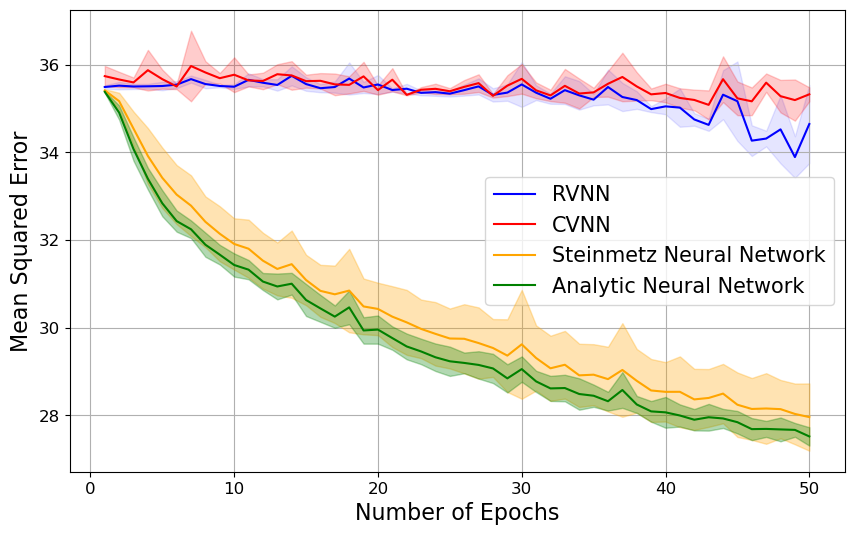

In [160]:
# Step 2: Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=0)
    std_error = np.std(data, axis=0) / np.sqrt(data.shape[0])  # Standard error of the mean
    stdev = np.std(data, axis=0)
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci, stdev

X = test_error_rvnn[:,:]; Y = test_error_cvnn[:,:]
Z = test_error_steinmetz[:,:]; A = test_error_analytic[:,:];
mean_X, ci_X, stdev_X = compute_mean_and_CI(X)
mean_Y, ci_Y, stdev_Y = compute_mean_and_CI(Y)
mean_Z, ci_Z, stdev_Z = compute_mean_and_CI(Z)
mean_A, ci_A, stdev_A = compute_mean_and_CI(A)

print(mean_X[-1], mean_Y[-1], mean_Z[-1], mean_A[-1])
print(stdev_X[-1], stdev_Y[-1], stdev_Z[-1], stdev_A[-1])

# Step 3: Plot the results
epochs_all = list(range(1, X.shape[1] + 1))
plt.figure(figsize=(10, 6))

# Plotting for X
plt.fill_between(epochs_all, mean_X - ci_X, mean_X + ci_X, color='blue', alpha=0.1, zorder=0)
plt.plot(epochs_all, mean_X, 'b-', label="RVNN", zorder=20)

# Plotting for Y
plt.fill_between(epochs_all, mean_Y - ci_Y, mean_Y + ci_Y, color='red', alpha=0.2, zorder=5)
plt.plot(epochs_all, mean_Y, 'r-', label="CVNN", zorder=25)

# Plotting for Z
plt.fill_between(epochs_all, mean_Z - ci_Z, mean_Z + ci_Z, color='orange', alpha=0.3, zorder=10)
plt.plot(epochs_all, mean_Z, '-', color='orange', label="Steinmetz Neural Network", zorder=30)

# Plotting for A
plt.fill_between(epochs_all, mean_A - ci_A, mean_A + ci_A, color='green', alpha=0.3, zorder=15)
plt.plot(epochs_all, mean_A, 'g-', label="Analytic Neural Network", zorder=35)

# Additional plot settings
plt.xlabel("Number of Epochs", fontsize=16)
plt.ylabel("Mean Squared Error", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('linear')
plt.legend(prop={'size': 15})
plt.grid(True)
plt.savefig('Results/RASPNet_epochs.png', bbox_inches='tight')
plt.show()